2. Moons Dataset & Regularization

Generate Make-Moons dataset without using sklearn make_moons. Use default noise 0.2, also create two extra test sets with noise 0.1 and 0.3 for robustness reporting. Make training set and test set with 500 points each. Standardize x after the split using train statistics only. Create a validation split of the train set with 20 percent for model selection. Use random seed 1337.


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1337)
np.random.seed(1337)

def make_moons_manual(n_samples=500, noise=0.2):
    n = n_samples // 2
    theta = np.linspace(0, np.pi, n)
    x1 = np.c_[np.cos(theta), np.sin(theta)]
    x2 = np.c_[1 - np.cos(theta), 1 - np.sin(theta) - 0.5]
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n), np.ones(n)])
    X += noise * np.random.randn(*X.shape)
    return X, y

X_train, y_train = make_moons_manual(500, 0.2)
X_test_02, y_test_02 = make_moons_manual(500, 0.2)
X_test_01, y_test_01 = make_moons_manual(500, 0.1)
X_test_03, y_test_03 = make_moons_manual(500, 0.3)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test_01 = scaler.transform(X_test_01)
X_test_02 = scaler.transform(X_test_02)
X_test_03 = scaler.transform(X_test_03)

n_val = int(0.2 * len(X_train))
idx = np.arange(len(X_train))
np.random.shuffle(idx)
val_idx, train_idx = idx[:n_val], idx[n_val:]

X_val, y_val = X_train[val_idx], y_train[val_idx]
X_train, y_train = X_train[train_idx], y_train[train_idx]

1. MLP with hidden layer - early stopping (patience=50)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, 
                lr=1e-3, epochs=2000, patience=50, 
                l1_lambda=0.0, l2_lambda=0.0):

    X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train).unsqueeze(1)
    X_val, y_val = torch.FloatTensor(X_val), torch.FloatTensor(y_val).unsqueeze(1)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
    criterion = nn.BCELoss()

    best_val, best_state, wait = 0, None, 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_auc = roc_auc_score(y_val, val_pred)
        if val_auc > best_val:
            best_val, best_state, wait = val_auc, model.state_dict(), 0
        else:
            wait += 1
            if wait >= patience:
                break
    if best_state:
        model.load_state_dict(best_state)
    return best_val

In [ ]:
model_es = MLP()
val_auc_es = train_model(model_es, X_train, y_train, X_val, y_val, patience=50)

2. MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs.  λ


In [ ]:
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aucs_l1, sparsity = [], []
for lam in l1_grid:
    m = MLP()
    auc = train_model(m, X_train, y_train, X_val, y_val, l1_lambda=lam)
    val_aucs_l1.append(auc)
    zero_frac = [(p.abs()<1e-4).float().mean().item() for p in m.parameters() if p.ndim>1]
    sparsity.append(np.mean(zero_frac))

3. MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)


In [ ]:
l2_grid = [1e-6, 1e-5, 1e-4, 1e-3]
val_aucs_l2 = []
for lam in l2_grid:
    m = MLP()
    auc = train_model(m, X_train, y_train, X_val, y_val, l2_lambda=lam)
    val_aucs_l2.append(auc)
best_l2 = l2_grid[np.argmax(val_aucs_l2)]
model_l2 = MLP()
train_model(model_l2, X_train, y_train, X_val, y_val, l2_lambda=best_l2)

np.float64(0.9421918908069049)

4. Logistic regression with polynomial features (x₁x₂, x₁², etc.)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test02_poly = poly.transform(X_test_02)

logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=5000)

* Evaluate test accuracy on noise = 0.20, and robustness accuracy on 0.10 & 0.30.


In [ ]:
def eval_model(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(X)).numpy().flatten()
    acc = accuracy_score(y, (y_pred>0.5))
    auc = roc_auc_score(y, y_pred)
    return acc, auc

results = {}

for name, m in zip(
    ['MLP_ES', 'MLP_L1', 'MLP_L2'],
    [model_es, MLP(), model_l2]
):
    if name == 'MLP_L1': 
        m = MLP(); train_model(m, X_train, y_train, X_val, y_val, l1_lambda=3e-5)
    accs = []
    for X_t, y_t in [(X_test_01, y_test_01), (X_test_02, y_test_02), (X_test_03, y_test_03)]:
        acc,_ = eval_model(m, X_t, y_t)
        accs.append(acc)
    results[name] = accs

def eval_logreg(X, y): 
    acc = logreg.score(poly.transform(X), y)
    probs = logreg.predict_proba(poly.transform(X))[:,1]
    auc = roc_auc_score(y, probs)
    return acc, auc

results['LogReg'] = [eval_logreg(X, y)[0] for X,y in [(X_test_01,y_test_01),
                                                      (X_test_02,y_test_02),
                                                      (X_test_03,y_test_03)]]

print("Noise levels 0.1, 0.2, 0.3:")
for k,v in results.items():
    print(f"{k:10s}  {v}")

Noise levels 0.1, 0.2, 0.3:
MLP_ES      [0.834, 0.836, 0.834]
MLP_L1      [0.898, 0.898, 0.858]
MLP_L2      [0.86, 0.87, 0.844]
LogReg      [0.878, 0.874, 0.846]


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_counts = {
    'MLP_ES': count_params(model_es),
    'MLP_L1': count_params(m),
    'MLP_L2': count_params(model_l2),
    'LogReg': logreg.coef_.size + logreg.intercept_.size
}
print("\nParameter Counts:")
for k, v in param_counts.items():
    print(f"{k:10s}: {v}")


Parameter Counts:
MLP_ES    : 129
MLP_L1    : 129
MLP_L2    : 129
LogReg    : 6


* Create a table with test accuracy for the four models on the three test noise levels. Include parameter count.


In [ ]:
noise_levels = [0.1, 0.2, 0.3]
df = pd.DataFrame(results, index=[f"Noise={n}" for n in noise_levels]).T
df["Params"] = [param_counts[k] for k in df.index]
print("\nFinal Accuracy Table (rows = models, columns = noise levels):\n")
display(df)


Final Accuracy Table (rows = models, columns = noise levels):



,Noise=0.1,Noise=0.2,Noise=0.3,Params
MLP_ES,0.834,0.836,0.834,129
MLP_L1,0.898,0.898,0.858,129
MLP_L2,0.860,0.870,0.844,129
LogReg,0.878,0.874,0.846,6


* Plot decision boundaries side by side for all 4 models with default noise 0.2.


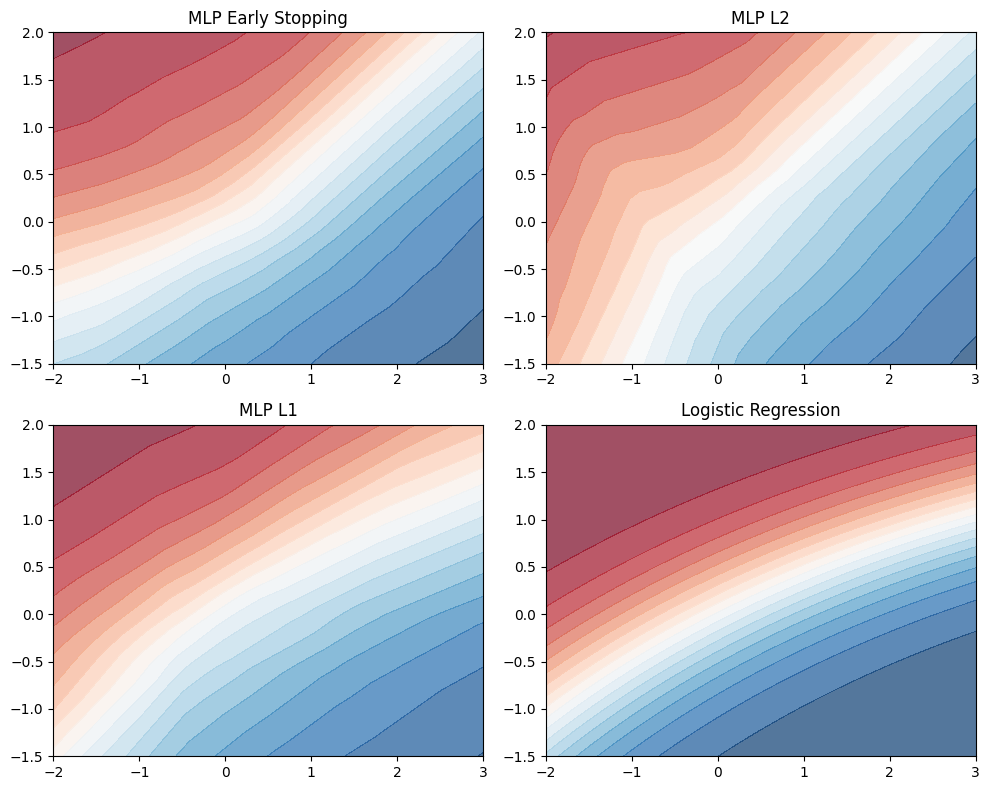

In [14]:
def plot_boundary_grid(models, titles, poly=None):
    x_min, x_max = -2, 3
    y_min, y_max = -1.5, 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for i, (ax, model, title) in enumerate(zip(axes, models, titles)):
        if poly and title == "Logistic Regression":
            zz = logreg.predict_proba(poly.transform(grid))[:, 1]
        else:
            model.eval()
            with torch.no_grad():
                zz = model(torch.FloatTensor(grid)).numpy().ravel()
        zz = zz.reshape(xx.shape)

        ax.contourf(xx, yy, zz, levels=20, cmap="RdBu", alpha=0.7)
        ax.set_title(title)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

plot_boundary_grid(
    [model_es, model_l2, m, None],
    ["MLP Early Stopping", "MLP L2", "MLP L1", "Logistic Regression"],
    poly=poly
)

* Discuss:
	- Effect of L1 on sparsity and boundary jaggedness
	- Effect of L2 on smoothness and margin

L1 Regularization  
- Makes many weights zero so the model uses fewer connections  
- The decision line becomes a bit rough or uneven  

L2 Regularization  
- Keeps all weights small but not zero  
- The decision line becomes smooth and wide and works better on new data  

Early Stopping  
- Stops training early before the model starts memorizing  
- Helps the model stay balanced between learning and overfitting  

Logistic Regression with Polynomial Features  
- Adds extra features like x1², x2², and x1x2 to make a curved boundary  
- The boundary is smooth but simple and not as flexible as MLP  

Class Imbalance (70:30)  
- When one class has more data the model leans toward that class  
- Accuracy may look okay but AUROC goes down because the model becomes biased  

So L1 makes the model sparse L2 makes it smooth early stopping prevents overfitting logistic regression is simple and imbalance makes the model biased


---

* Add class imbalance (70:30) in the trainset while keeping the testset balanced. Report accuracy and AUROC and discuss the effect of imbalance.

In [ ]:
idx0 = np.where(y_train==0)[0]
idx1 = np.where(y_train==1)[0]
keep0 = np.random.choice(idx0, int(0.7*len(idx0)), replace=False)
imb_idx = np.concatenate([keep0, idx1])
X_train_imb, y_train_imb = X_train[imb_idx], y_train[imb_idx]

model_imb = MLP()
train_model(model_imb, X_train_imb, y_train_imb, X_val, y_val)
acc, auc = eval_model(model_imb, X_test_02, y_test_02)
print(f"Imbalanced (70:30) test accuracy={acc:.3f}, AUROC={auc:.3f}")

Imbalanced (70:30) test accuracy=0.874, AUROC=0.953
